# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:

/datasets/geo_data_0.csv \
/datasets/geo_data_1.csv \
/datasets/geo_data_2.csv 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Предобработка данных

In [1]:
import pandas as pd # импортируем библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv') # открываем файлы
data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [4]:
def check_data(data_df): # первичный анализ
    print ('\033[1m' + 'Исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк, содержащих пропуски: {:.1%}'.format(missed_rows))

    # Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    # Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)  

In [5]:
def graphs(df):
    f, (ax_box, ax_hist) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))
    sns.boxplot(data=df, x='product', ax=ax_box).set(title='Объём и количество запасов в скважине')
    sns.histplot(data=df, x='product', ax=ax_hist, bins=30, kde=True)
    ax_box.set(xlabel='')
    plt.xlabel("Объём запасов в скважине (тыс. баррелей)")
    plt.ylabel("Количество")
#    plt.xlim(0, 30)
    plt.show()

In [6]:
check_data(data_0)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк, содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


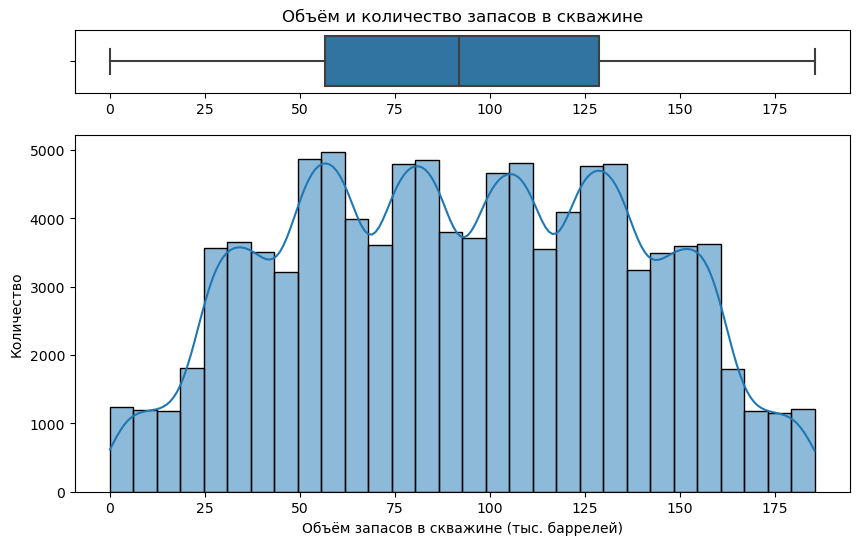

In [7]:
graphs(data_0)

In [8]:
check_data(data_1)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк, содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


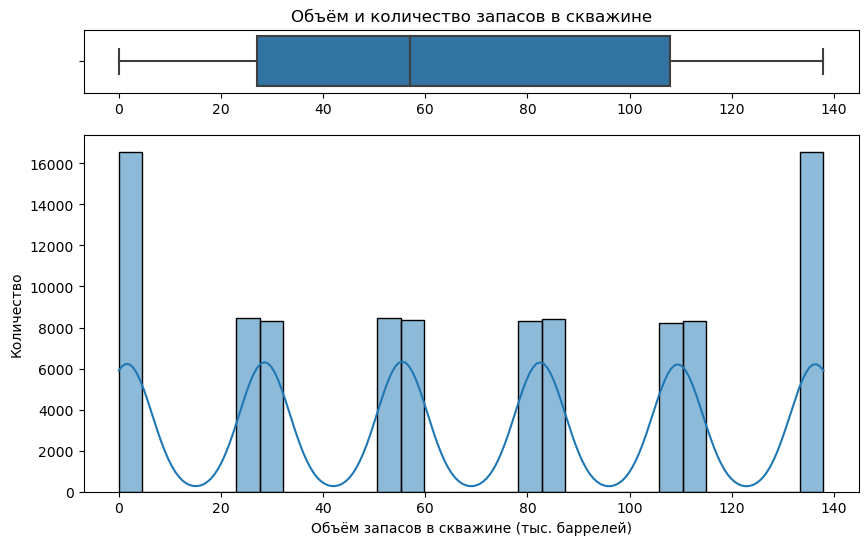

In [9]:
graphs(data_1)

In [10]:
check_data(data_2)

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк, содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


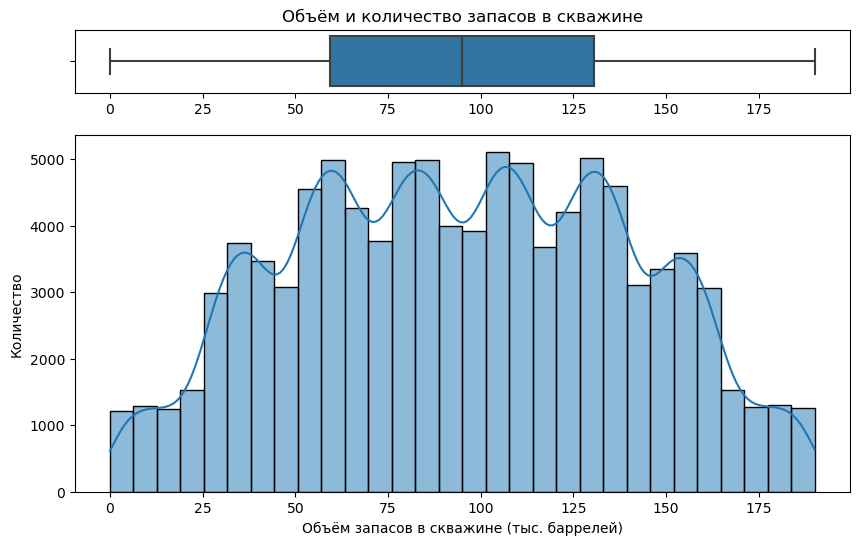

In [11]:
graphs(data_2)

In [12]:
data_0.drop(['id'], axis=1, inplace=True) #удаляем нерелевантные столбцы
data_1.drop(['id'], axis=1, inplace=True)
data_2.drop(['id'], axis=1, inplace=True)

In [13]:
data_0.head(5) # check

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [14]:
data_1.head(5) # check

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [15]:
data_2.head(5) # check

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


### Проверка корреляций

In [16]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [17]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [18]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


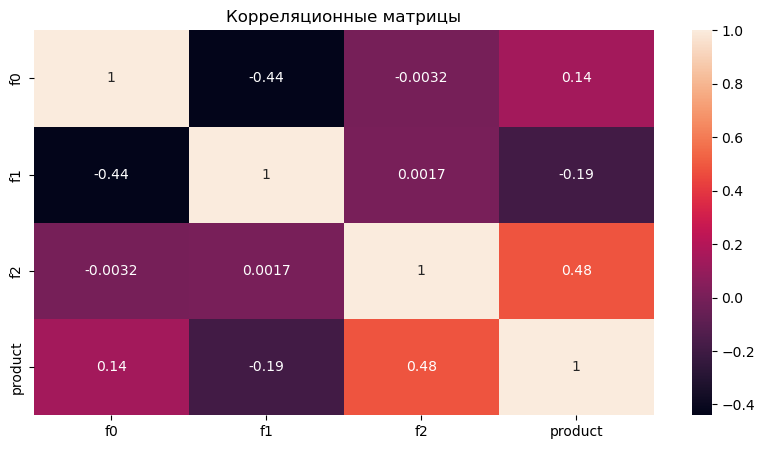

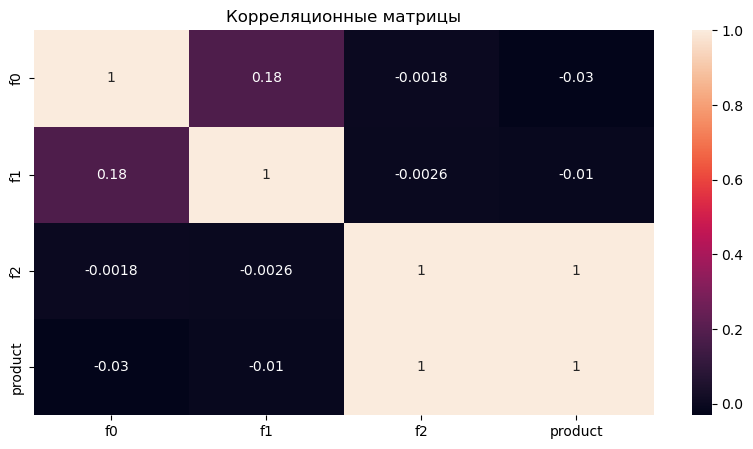

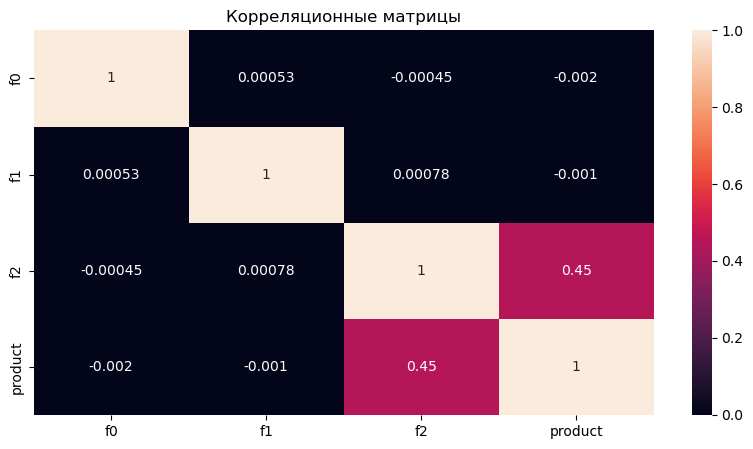

In [19]:
for i in [data_0, data_1, data_2]:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 1, 1)
    plt.title('Корреляционные матрицы')
    sns.heatmap(i.corr(), annot = True);

<Figure size 1000x500 with 0 Axes>

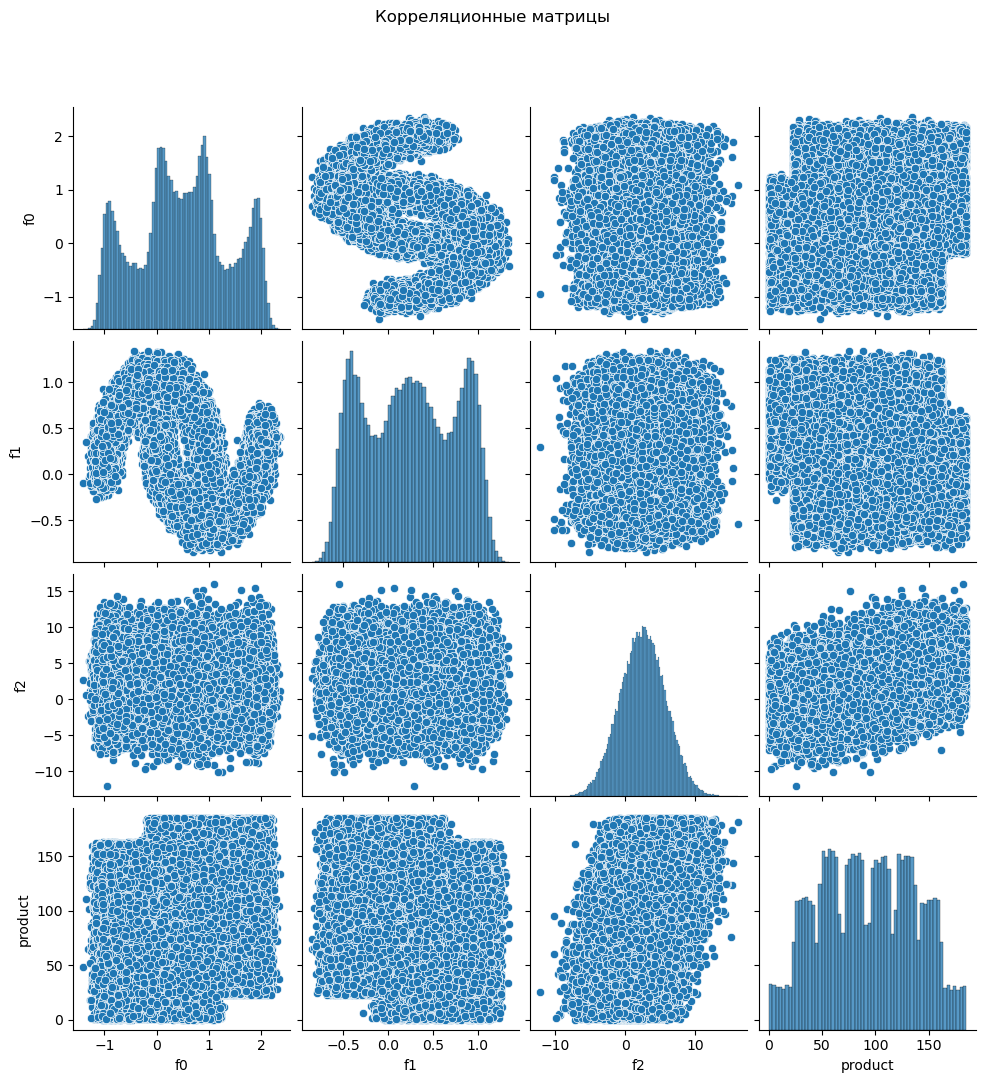

<Figure size 1000x500 with 0 Axes>

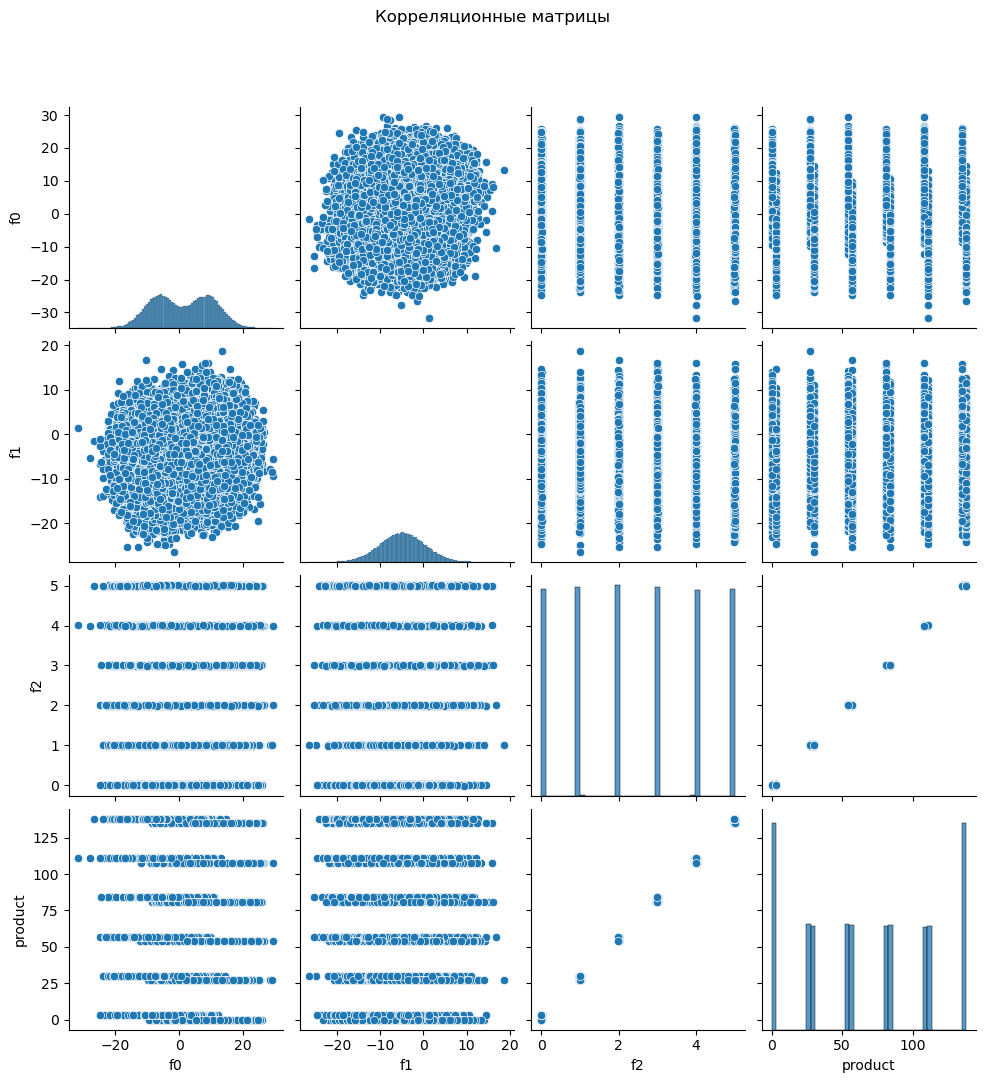

<Figure size 1000x500 with 0 Axes>

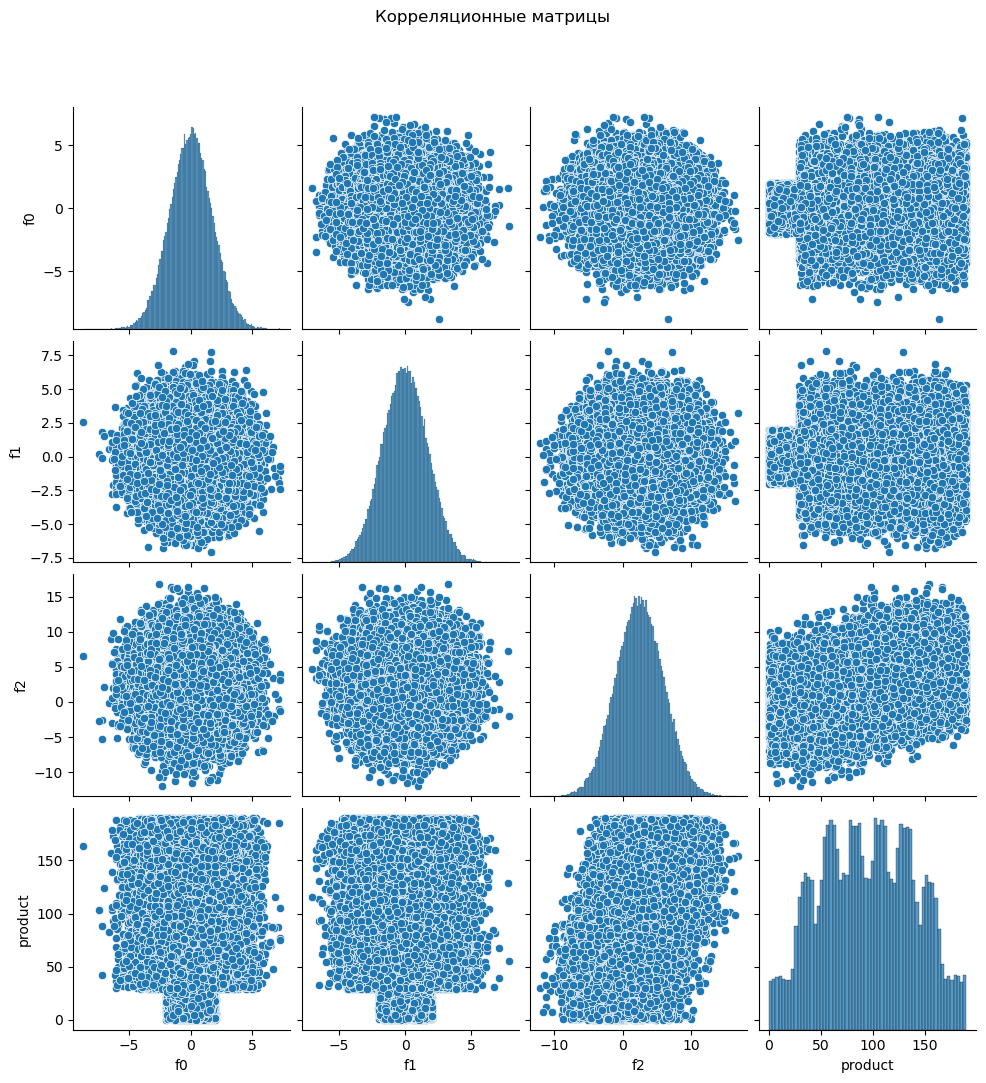

In [20]:
for i in [data_0, data_1, data_2]:
    plt.figure(figsize=(10, 5))
    g = sns.pairplot(i)
    g.fig.suptitle("Корреляционные матрицы", y=1.08)

### Промежуточные выводы

По результатам предобработки данных: 
- дубликаты не выявлены;
- пропуски не выявлены;
- названия столбцов оформлены в соответствии со змеиным синтаксисом;
- типы данных соотвутствуцют содержанию столбцов;
- проверены корреляции между признаками и целевым (наблюдается средняя корреляция во всех регионах между признаком f2 и целевым, при этом во 2-м регионе коэф. корр. в этом случае = 1, что свидетельствует о высокой степени корреляции);
- удален столбец 'id', который не представляет ценности для дальнейшего анализа.

## Обучение и проверка модели

In [21]:
features_0 = data_0.drop('product', axis=1)
target_0 = data_0['product']

# Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25.
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

In [22]:
model_0 = LinearRegression() # инициализируем модель LinearRegression
model_0.fit(features_train_0, target_train_0) # обучаем модель на тренировочной выборке
predictions_valid_0 = model_0.predict(features_valid_0) # получаем предсказания модели на валидационной выборке

result_0 =  mean_squared_error(target_valid_0, predictions_valid_0)**0.5 # посчитаем значение метрики RMSE на валидационной выборке
predictions_valid_mean_0 = predictions_valid_0.sum() / len(predictions_valid_0)
print("RMSE модели линейной регрессии на валидационной выборке 1-го региона:", result_0)
print('Средний запас предсказанного сырья 1-го региона:', predictions_valid_mean_0)

RMSE модели линейной регрессии на валидационной выборке 1-го региона: 37.5794217150813
Средний запас предсказанного сырья 1-го региона: 92.59256778438035


In [23]:
features_1 = data_1.drop('product', axis=1)
target_1 = data_1['product']

# Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25.
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [24]:
model_1 = LinearRegression() # инициализируем модель LinearRegression
model_1.fit(features_train_1, target_train_1) # обучаем модель на тренировочной выборке
predictions_valid_1 = model_1.predict(features_valid_1) # получаем предсказания модели на валидационной выборке

result_1 =  mean_squared_error(target_valid_1, predictions_valid_1)**0.5 # посчитаем значение метрики RMSE на валидационной выборке
predictions_valid_mean_1 = predictions_valid_1.sum() / len(predictions_valid_1)
print("RMSE модели линейной регрессии на валидационной выборке 2-го региона:", result_1)
print('Средний запас предсказанного сырья 2-го региона:', predictions_valid_mean_1)

RMSE модели линейной регрессии на валидационной выборке 2-го региона: 0.8930992867756168
Средний запас предсказанного сырья 2-го региона: 68.728546895446


In [25]:
features_2 = data_2.drop('product', axis=1)
target_2 = data_2['product']

# Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25.
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

In [26]:
model_2 = LinearRegression() # инициализируем модель LinearRegression
model_2.fit(features_train_2, target_train_2) # обучаем модель на тренировочной выборке
predictions_valid_2 = model_2.predict(features_valid_2) # получаем предсказания модели на валидационной выборке

result_2 =  mean_squared_error(target_valid_2, predictions_valid_2)**0.5 # посчитаем значение метрики RMSE на валидационной выборке
predictions_valid_mean_2 = predictions_valid_2.sum() / len(predictions_valid_2)
print("RMSE модели линейной регрессии на валидационной выборке 3-го региона:", result_2)
print('Средний запас предсказанного сырья 3-го региона:', predictions_valid_mean_2)

RMSE модели линейной регрессии на валидационной выборке 3-го региона: 40.02970873393434
Средний запас предсказанного сырья 3-го региона: 94.96504596800489


### Промежуточные выводы

Согласно полученным данным можно сделать следующие выводы:

1. Наиболее низкий результат средней квадратичной ошибки дает 2-й регион.
2. Наиболее значительный средний запас сырья наблюдается в третьем регионе, при этом RMSE выше, чем у остальных регионов.


## Подготовка к расчёту прибыли

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [27]:
OIL_DERRICS = 200 # ключевые значения для расчётов сохраняем в отдельных переменных
ALL_OIL_DERRICS = 500
BUDGET = 10000000000
REVENUE = 450000
STATE = np.random.RandomState(12345)

In [28]:
volume = BUDGET / OIL_DERRICS / REVENUE # рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
print('Достаточный объём для безубыточной разработки новой скважины:', volume, 'тыс. барр.')

Достаточный объём для безубыточной разработки новой скважины: 111.11111111111111 тыс. барр.


### Промежуточные выводы

Средний объём скважен во всех трех регионах (92.59, 68.72 и 94.96 соответственно) не достаточен для безубыточной разработки новой скважины (111.11).

## Расчёт прибыли и рисков 

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

- Выберите скважины с максимальными значениями предсказаний. 
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.

In [29]:
predictions_valid_0 = pd.Series(predictions_valid_0, index = target_valid_0.index) # приводим данные к Series

In [30]:
predictions_valid_1 = pd.Series(predictions_valid_1, index = target_valid_1.index)

In [31]:
predictions_valid_2 = pd.Series(predictions_valid_2, index = target_valid_2.index)

In [32]:
def profit(target, probabilities): 
    probs_sorted = probabilities.sort_values(ascending=False)
    selected_max = target[probs_sorted.index][:OIL_DERRICS]
    return REVENUE * selected_max.sum() - BUDGET

In [33]:
print('Прибыль для полученного объёма сырья по 1-му региону:', round(profit(target_valid_0, predictions_valid_0) / 1000000000, 2), 'млрд. р.')
print('Прибыль для полученного объёма сырья по 2-му региону:', round(profit(target_valid_1, predictions_valid_1) / 1000000000, 2), 'млрд. р.')
print('Прибыль для полученного объёма сырья по 3-му региону:', round(profit(target_valid_2, predictions_valid_2) / 1000000000, 2), 'млрд. р.')

Прибыль для полученного объёма сырья по 1-му региону: 3.32 млрд. р.
Прибыль для полученного объёма сырья по 2-му региону: 2.42 млрд. р.
Прибыль для полученного объёма сырья по 3-му региону: 2.71 млрд. р.


### Риски и прибыль для каждого региона:
- 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [34]:
region = ['Регион 1', 'Регион 2', 'Регион 3']

def risks(tg, pred, num):
    values = []
    for i in range(1000):
        target_subsample = tg.sample(n = ALL_OIL_DERRICS, replace = True, random_state = STATE)
        probs_subsample = pred.loc[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample))

    values = pd.Series(values)
#     print(values)
#     return
    lower = values.quantile(0.025) / 1000000
    upper = values.quantile(0.975) / 1000000
    risk = (values < 0).mean()*100
    mean = values.mean() / 1000000
    print(region[num])
    print('Средняя прибыль:', round(mean, 2), 'млн.р.')
    print('Доверительный интервал 95%:', round(lower, 2), '-', round(upper, 2),'млн.р.')
    print('Риск убытка:', round(risk, 2), '%')

In [35]:
risks(target_valid_0, predictions_valid_0, 0)

Регион 1
Средняя прибыль: 425.94 млн.р.
Доверительный интервал 95%: -102.09 - 947.98 млн.р.
Риск убытка: 6.0 %


In [36]:
risks(target_valid_1, predictions_valid_1, 1)

Регион 2
Средняя прибыль: 518.26 млн.р.
Доверительный интервал 95%: 128.12 - 953.61 млн.р.
Риск убытка: 0.3 %


In [37]:
risks(target_valid_2, predictions_valid_2, 2)

Регион 3
Средняя прибыль: 420.19 млн.р.
Доверительный интервал 95%: -115.85 - 989.63 млн.р.
Риск убытка: 6.2 %


## Выводы

1. Данные прошли **предобработку**:

- дубликаты и пропуски не выявлены;
- названия столбцов соотвутсвуют змеиным синтаксису;
- типы данных соотвутстветствуют содержанию столбцов;
- проверены корреляции между признаками и целевым (отметим наличиее корреляции во всех регионах между признаком f2 и целевым, при этом в 1-м и 3-м регионах корреляция средняя, а во 2-м регионе коэф. корр. в этом случае = 1, что свидетельствует о высокой степени корреляции);
- удален столбец 'id', который не нужен для дальнейшего анализа.

2. При **обучении и проверке модели** было установлено, что:

- наиболее низкий результат средней квадратичной ошибки дает 2-й регион.
- наиболее значительный средний запас сырья наблюдается в 3-м регионе, при этом RMSE там выше, чем у остальных регионов.

3. **Расчет прибыли и рисков**:

- средний объём скважен во всех трех регионах (92.59, 68.72 и 94.96 соответственно) не достаточен для безубыточной разработки новой скважины (111.11).
- данные по 3-м регионам следуюшие:

     - Регион 1
     - Средняя прибыль: 425.94 млн.р.
     - Доверительный интервал 95%: -102.09 - 947.98 млн.р.
     - Риск: 6.0 %


     - Регион 2
     - Средняя прибыль: 518.26 млн.р.
     - Доверительный интервал 95%: 128.12 - 953.61 млн.р.
     - Риск: 0.3 %

     - Регион 3
     - Средняя прибыль: 420.19 млн.р.
     - Доверительный интервал 95%: -115.85 - 989.63 млн.р.
     - Риск: 6.2 %

**Для разработки предлагается Регион 2** (даже при учете того, что самый большой средний запас сырья находится в 3-м регионе), так как по результатам анализа разработка скважин в этом регионе минимальный риск убытка (0.3%), а также предполагает самую высокую среднюю прибыль (518.26 млн.р.) и имеет положительные значения доверительного интервала по сравнению с другимим регионами. 